![](https://www.melhoresdestinos.com.br/wp-content/uploads/2015/11/Dicas-Airbnb.jpg)<br><br>

Airbnb is an **online marketplace** for short-term house and apartment rentals. With it you can, for example, rent out your house for a week while you’re away, or rent out your empty bedroom. Since Airbnb is a market, pricing works just like anything in life: the amount a host usually charges is closely tied to market prices(supply and demand). The search experience on Airbnb looks like this:

<br><br>
![](https://66.media.tumblr.com/f06784bb36b2d0d2914d1bb8af40f48d/tumblr_nnhegoQEfu1ur02gdo1_1280.png)
<br><br>
**Goal of the analysis**

As seen above, the general Airbnb host is someone who has some spare space and want to get some revenue, without having to worry too much about advertising and insurance. 
Airbnb does it all for the host, but there is one thing it can't do: help price their property. Since the price can vary a lot according to country, currency, neighborhood and the host itself, it is simply too complex to provide a general service on that.
<br>
The goal of the analysis is to visualize and clean overall Airbnb data from **Rio de Janeiro**, and then build a predictive model specific to the city, in order to assist hosts from Rio to price their listings based on the market standard.
<br>
Since the model is intended to be used by the general public, possibly some accuracy will be given up in exchange for a higher simplicity.
<br>

**Deployment**

After the model is complete, the goal is to make it available to the general public, first on a web application, and on the future, possibly on an app available to **Android** and **iPhone**. <br>



**Data**

The dataset used contains detailed data about every listing on the site for every month(except june 2018, the source did not scrape data for that month), from april 2018, to may 2020. The main characteristics I consider to be relevant for our model are:

`Seasonality`: do prices tend to raise or decrease at specific months?
`Features of the listing`: How big is the property? how many bedrooms, beds and bathrooms?
`Behavior of the host`: Do listings with more detailed description tend to be priced higher? Does the host demand clear identification from the renter?
`Neighborhood`: How much does the geographic position influences the price?

**The currency for every price contained in the dataset is reais(R$).**<br><br>

![](https://super.abril.com.br/wp-content/uploads/2017/12/rio-de-janeiro.png)


**Credits**

I want to thank [duygut](https://www.kaggle.com/duygut) for this [great work](https://www.kaggle.com/duygut/airbnb-nyc-price-prediction) on a similar dataset from NYC. Reading it made me learn a lot of statistics and get inspiration for some data visualizations.

First, we import the necessary modules for our analysis:

In [1]:
import numpy as np #Deal with numbers and arrays
import pandas as pd #Create dataframes and sort/clean data faster

import matplotlib.pyplot as plt #Visualization module
import seaborn as sns #Makes matplotlib prettier

#This blocks imports everything needed from sklearn(models, procession packages, and metrics)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor # XGB regression model
import plotly.express as px #Module for dynamic data visualization

Just for note: this is the code used to generate the dataset used. More info on how it works [here].(https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro)

```
#THIS PART OF THE CODE RAN ONLY ONCE, AND IT'S WHAT MERGED THE DATASETS USED IN THIS ANALYSIS
df = pd.DataFrame()
filenames = {'agosto2018':8, 'setembro2018':9, 'outubro2018':10, 'novrmbro2018':11, 'dezembro2018':12,'janeiro2019':1, 'fevereiro2019':2, 'maro2019':3, 'abril2019':4, 'maio2019':5, 'junho2019':6, 'julho2019':7, 'agosto2019':8, 'setembro2019':9, 'outubro2019':10, 'novembro2019':11, 'dezembro2019':12, 'janeiro2020':1, 'fevereiro2020':2, 'maro2020':3, 'abril2020':4, 'maio2020':4}

for month, month_number in filenames.items():
    df_month = pd.read_csv(f'../input/airbnb-rio-de-janeiro/{month}.csv')
    df_month['month'] = month_number
    df = df.append(df_month)

df.to_csv('total_data.csv')
```

### Columns of the dataframe:

The initial goal was to load the entire dataframe and look into every column, but that led to some memory leak. So, in order to make the analysis possible, and to be able to run every single model trial, we'll only import the columns used in the model.
<br>
For more info on every column available, check the [dataset](https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro).<br><br>

More about each feature chosen:

- `host_is_superhost`: t for true and f for false. Says if the host is a superhost, which indicates its credibility with the platform<br>
- `host_listings_count`: amount of listings the host has on the market.<br>
- `'property_type`: the kind of property(apartment, house).<br>
- `accommodates`: the maximum amount of people that can be in the listing at a time.<br>
- `bathrooms`: amount of bathrooms.<br>
- `bedrooms`: amount of bedrooms.<br>
- `beds`: amount of beds.<br>
- `amenities`: refers to whether the listing has TV, wifi, wir conditioning, and much more amenities.<br>
- `price`: price charged for a day(doesn't include promotional prices to full weeks).<br>
- `require_guest_profile_picture`: Iif the host requires that the guest has a profile picture(safety measure).<br>
- `require_guest_phone_verification`: if the host requires that the guest has the phone number verified(safety measure).<br>
- `month`: month it was scraped from the web(corresponds to 1-12, and doesn't tell the year).<br>
- `security_deposit`: if the host requires a safety deposit in case anything breaks.<br>
- `cleaning_fee`: if the host requires a cleaning fee, charged everytime a listing is rented.

Parsing the dataset into a pandas data frame

In [2]:
df = pd.read_csv('../input/airbnb-rio-de-janeiro/total_data.csv', index_col=False, usecols=['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'property_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'amenities', 'price', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'month', 'security_deposit','cleaning_fee'])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (33,54) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Initial parsing of dataset

First, let's take a look at the dataset:

In [3]:
df.head()

,host_is_superhost,host_listings_count,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,require_guest_profile_picture,require_guest_phone_verification,month
0,f,2,-22.965919,-43.178962,Condominium,5,1.0,2.0,2.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$307.00,$0.00,$311.00,f,f,8.0
1,f,1,-22.985698,-43.201935,Apartment,2,1.0,1.0,1.0,"{TV,""Cable TV"",Wifi,""Air conditioning"",""First ...",$233.00,$889.00,$220.00,f,f,8.0
2,f,3,-22.977117,-43.190454,Apartment,3,1.0,1.0,2.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$159.00,"$1,000.00",$220.00,t,t,8.0
3,t,1,-22.983024,-43.214270,Apartment,3,1.0,1.0,2.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$253.00,$0.00,$78.00,f,f,8.0
4,f,1,-22.988165,-43.193588,Apartment,3,1.5,1.0,2.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$350.00,$971.00,$152.00,t,t,8.0


Shape of the dataset:

In [4]:
print(f'Rows: {df.shape[0]}, Columns: {df.shape[1]}')

Rows: 784122, Columns: 16


Checking for NaN's

In [5]:
df.isnull().sum()

host_is_superhost                      386
host_listings_count                    386
latitude                                 1
longitude                                1
property_type                            1
accommodates                             1
bathrooms                             1494
bedrooms                               776
beds                                  2335
amenities                                1
price                                    1
security_deposit                    361064
cleaning_fee                        269336
require_guest_profile_picture            2
require_guest_phone_verification         2
month                                    2
dtype: int64

In [6]:
total_rows = df.shape[0]
print(f'security_deposit missing values are in {round(361064*100/total_rows,1)}% of rows, and cleaning_fee missing values are in {round(269336*100/total_rows,1)}% of rows.')

security_deposit missing values are in 46.0% of rows, and cleaning_fee missing values are in 34.3% of rows.


Dropping `security_deposit` and `cleaning_fee` from the dataset seems to be the most optimal decision, since those variables have simply way too much missing values compared to other variables.

In [7]:
rows_before_drop = df.shape[0]
df.drop(['security_deposit','cleaning_fee'], axis=1, inplace=True)
print(f"'security_deposit' and 'cleaning fee' dropped :)")

'security_deposit' and 'cleaning fee' dropped :)


Since we have a lot of data, we can afford to drop the most obvious NaN's. In the code next ahead, rows with any missing value will be dropped from the dataset.

In [8]:
df.dropna(inplace=True)
print(f'{df.shape} - {rows_before_drop-df.shape[0]} rows dropped')

(780035, 14) - 4087 rows dropped


Check if there is any missing value left:

In [9]:
df.isnull().sum()

host_is_superhost                   0
host_listings_count                 0
latitude                            0
longitude                           0
property_type                       0
accommodates                        0
bathrooms                           0
bedrooms                            0
beds                                0
amenities                           0
price                               0
require_guest_profile_picture       0
require_guest_phone_verification    0
month                               0
dtype: int64

Now, it is wise to check if any column has any kind of unusual value or data type:

### Checking data types

In [10]:
df.dtypes

host_is_superhost                    object
host_listings_count                  object
latitude                            float64
longitude                           float64
property_type                        object
accommodates                         object
bathrooms                           float64
bedrooms                            float64
beds                                float64
amenities                            object
price                                object
require_guest_profile_picture        object
require_guest_phone_verification     object
month                               float64
dtype: object

- `host_listings_count` Should be a `integer` column, not `object`

- `accommodates` should also be an `integer` column, not `object`

- `price should` also be an + `integer` column, not `object`

In [11]:
# CHANGING DATA TYPES

#host_listings_count
df['host_listings_count'] = df['host_listings_count'].astype(np.float32, copy=False)
df['host_listings_count'] = df['host_listings_count'].astype(np.int16, copy=False)
#accommodates
df['accommodates'] = df['accommodates'].astype(np.int16, copy=False)
#price
df['price'] = df['price'].str.replace('$', '', regex=False)
df['price'] = df['price'].str.replace(',', '', regex=False)
df['price'] = df['price'].astype(np.float32, copy=False)
df['price'] = df['price'].astype(np.int32, copy=False)

**For programmers**: whenever you have a massive amount of data, it is a good habit to check if you can convert integers and floats from 64 bits to 8-16-32 bits. On a large scale, it represents a significant additional amount of memory available for other uses.

Now we're good to get into...

### Exploratory data analysis along with data cleaning

The EDA in the notebook will be performed in each variable that contains outliers, in a way that you can visualize the difference how dealing with outliers improves the overall distribution of a dataset.
<br>
<br>
### Dealing with outliers
To better deal with outliers than simply remove it by intuition, we'll use the **descriptive statistic** method [**interquartile range**](https://en.wikipedia.org/wiki/Interquartile_range).<br>
First, define a function to get the `max_fence_value`, which is defined as the highest value a variable can have so that it is not considered an outlier. Any value bigger than that will go through some sort of modification.

In [12]:
def get_max_fence(column):
    qt = df[column].quantile([0.25,0.75])
    upper = qt.values[1]
    iqr = upper-qt.values[0]
    max_fence = upper + 1.5*(iqr)
    return max_fence

Next, a function to help us better visualize the IQR:

In [13]:
def box_plot(column):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(16,6)
    _ = sns.boxplot(x=df[column], ax = ax1)
    ax1.set_title(f'{column} boxplot')
    ax2.set_title(f'Zooming in the {column} boxplot')
    ax2.set_xlim((-0.1,1.1*get_max_fence(column)))
    _ = sns.boxplot(x=df[column], ax = ax2)

First adjustment: `host_listings_count`

Let's take a look at its distribution:

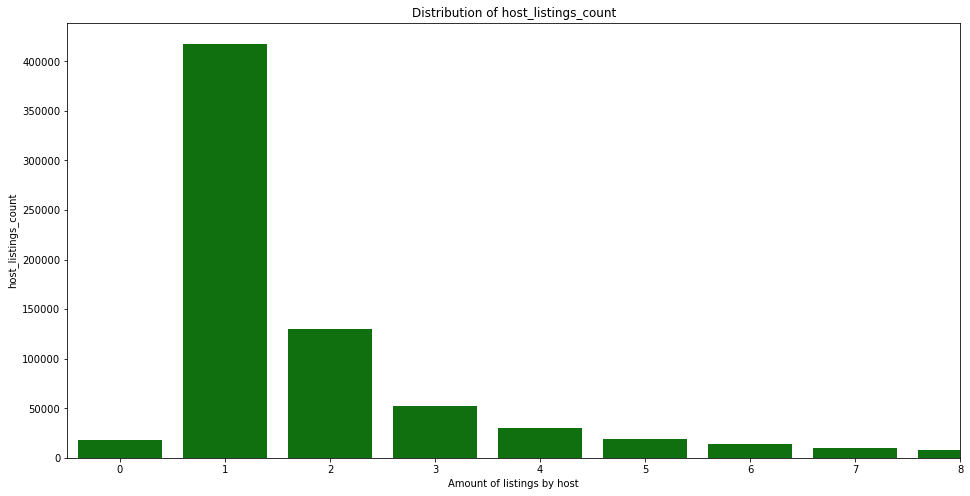

In [14]:
column = 'host_listings_count'
plt.figure(figsize=(16,8))
ax = sns.barplot(x=df[column].value_counts().index, y=df[column].value_counts(), color='g')
ax.set_xticklabels(map(int,df['beds'].index))
ax.set_xlim((-0.5,get_max_fence(column)+2))
ax.set_xlabel('Amount of listings by host')
_ = ax.set_title('Distribution of host_listings_count')

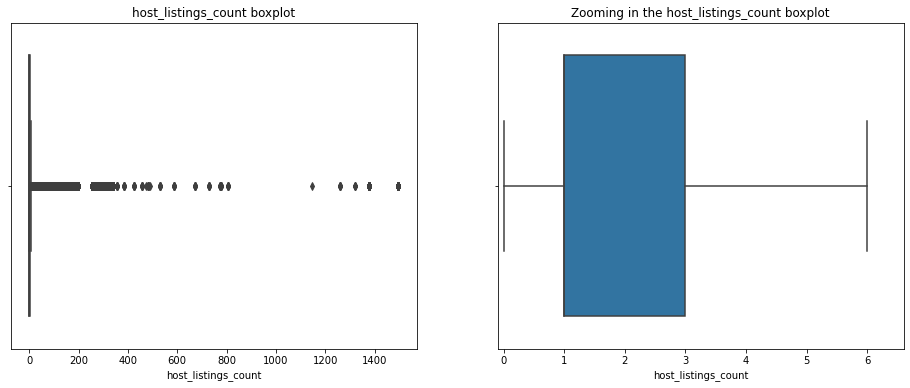

In [15]:
column = 'host_listings_count'
box_plot(column)

In [16]:
print(get_max_fence('host_listings_count'))

6.0


According to the method chosen, values bigger than 6 are outliers. We have a lot of outlying data. So, what do we do?

Since the goal of the study is to predict how regular people with one or a few vacant properties price them, hosts with more than 6 properties will be deleted from the analysis(this helps removing companies that rent on Airbnb and have way more listings than usual).

In [17]:
rows_before = df.shape[0]
df = df[df['host_listings_count'] <= get_max_fence('host_listings_count')]
print(f'{rows_before-df.shape[0]} rows were deleted.')

99528 rows were deleted.


This boxplot also shows us that there is some zero values. These values will be changed to 1, since if the hosts didn't have any listing, they wouldn't be on the dataset in the first place.

In [18]:
df.loc[df['host_listings_count'] == 0.0, 'host_listings_count'] = 1.0

Now we're good

**PRICE**

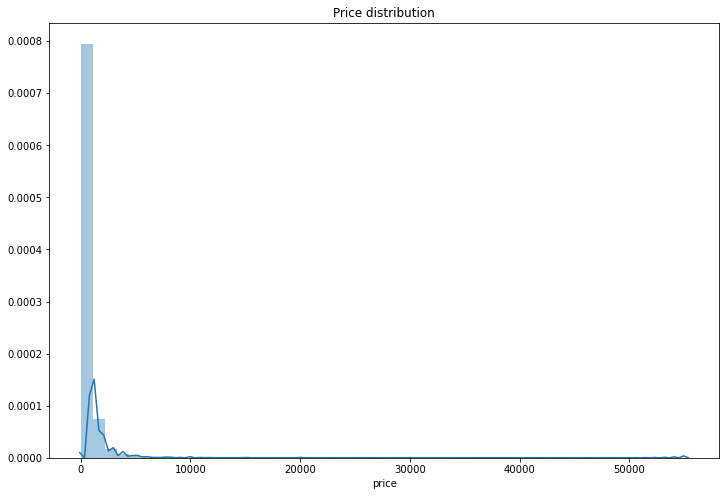

In [19]:
plt.figure(figsize=(12,8))
ax = sns.distplot(df['price'],norm_hist=True)
_ = ax.set_title('Price distribution')

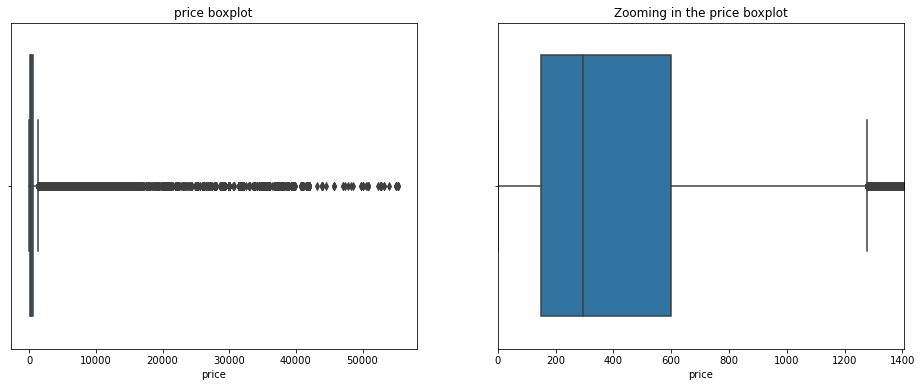

In [20]:
box_plot('price')

In [21]:
get_max_fence('price')

1276.0

This shows us that the daily prices over 1276 reais are outliers of our regression, so let's remove them.


In [22]:
rows_before = df.shape[0]
df = df[df['price'] <= get_max_fence('price')]
print(f'{rows_before-df.shape[0]} rows were removed')

66365 rows were removed


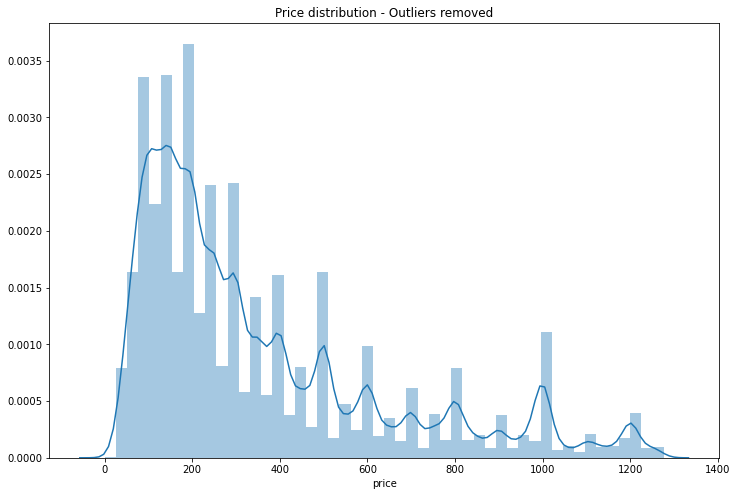

In [23]:
plt.figure(figsize=(12,8))
ax = sns.distplot(df['price'],norm_hist=True)
_ = ax.set_title('Price distribution - Outliers removed')

**The interesting thing that shows us how human the dataset is, is that there are peaks at full values(400,600,1000), which shows a human common behavior: rounding values.**

**PROPERTY TYPE**

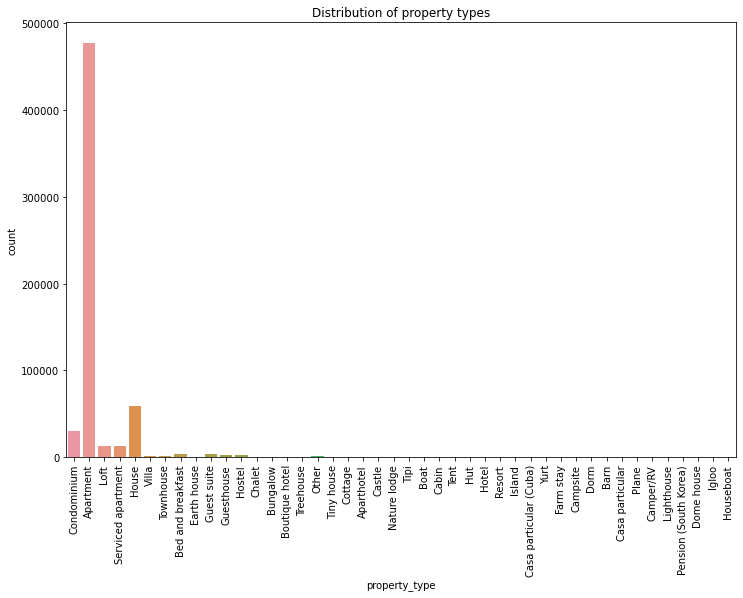

In [24]:
plt.figure(figsize=(12,8))
ax = sns.countplot('property_type', data=df)
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title('Distribution of property types')

For the sake of simplifying categorical variables, we will be appending every property type with less than 1000 occurrences to a single category, called "Other".

In [25]:
categories_to_append = ('Aparthotel', 'Earth house', 'Chalet', 'Cottage', 'Tiny house',
                        'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Bungalow',
                        'Nature lodge', 'Cabin', 'Castle', 'Treehouse', 'Island', 'Boat', 'Tent',
                        'Resort', 'Hut', 'Campsite', 'Barn', 'Dorm', 'Camper/RV', 'Farm stay', 'Yurt',
                        'Tipi', 'Pension (South Korea)', 'Dome house', 'Igloo', 'Casa particular',
                        'Houseboat', 'Lighthouse', 'Plane', 'Train', 'Parking Space')

for cat in categories_to_append:
    df.loc[df['property_type'] == cat, 'property_type'] = 'Other'

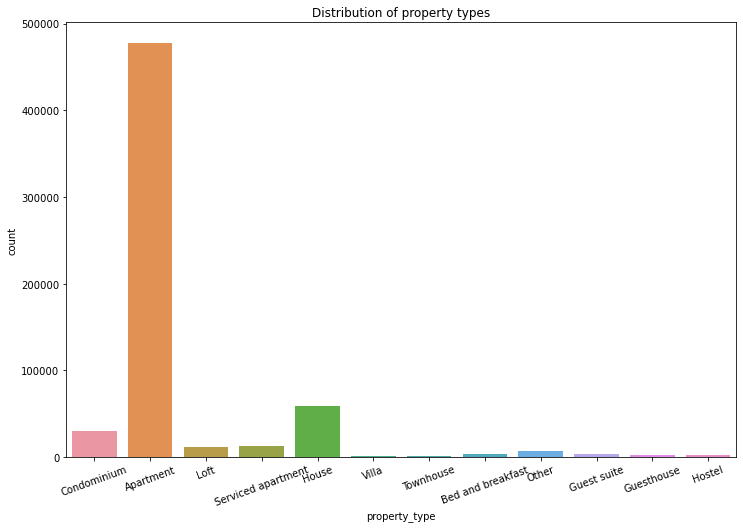

In [26]:
plt.figure(figsize=(12,8))
ax = sns.countplot('property_type', data=df)
ax.tick_params(axis='x', rotation=20)
_ = ax.set_title('Distribution of property types')

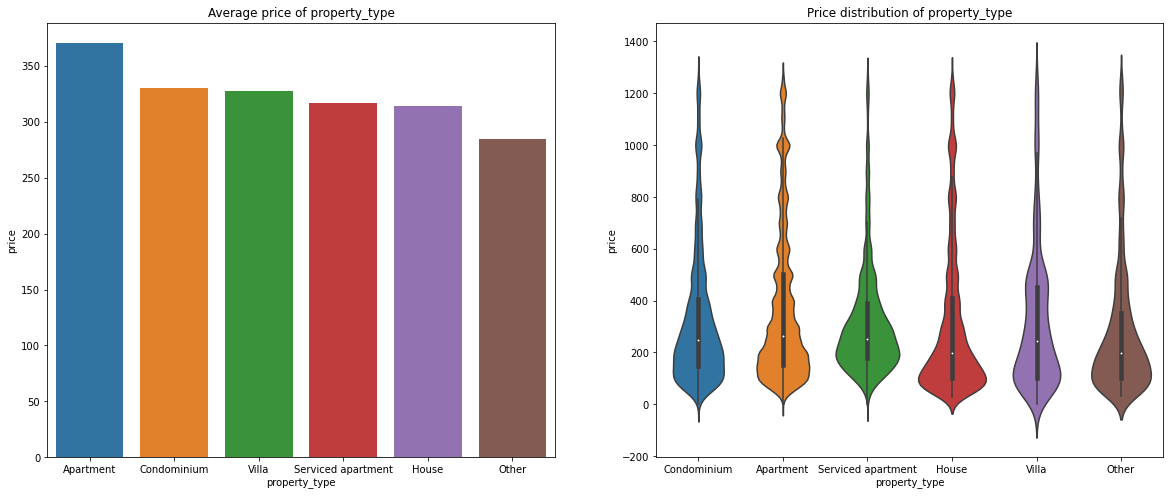

In [27]:
aa = df.groupby(by='property_type').mean().sort_values(by='price',ascending=False).iloc[0:6]
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(20,8)
violin_data=df.loc[df['property_type'].isin(aa.index)]
_ =  sns.barplot(x=aa.index, y='price', data=aa,ax=ax1)
_ = ax1.set_title('Average price of property_type')
_ = ax2.set_title('Price distribution of property_type')
_ = sns.violinplot(x = 'property_type', y =  'price',data=violin_data,ax=ax2)

**BEDS**

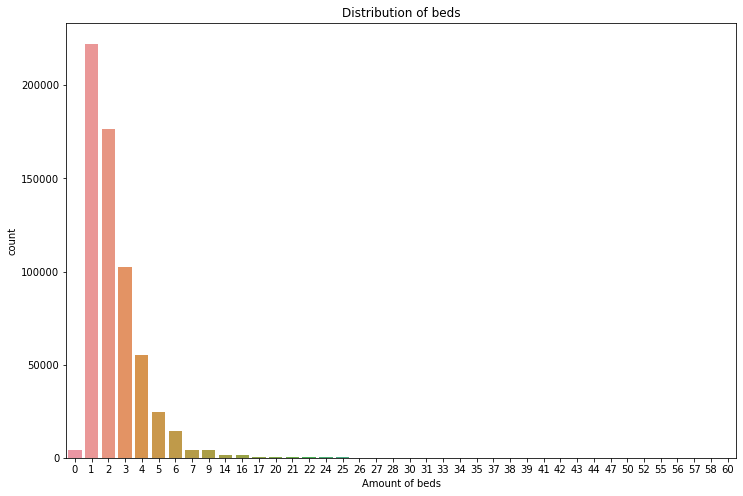

In [28]:
plt.figure(figsize=(12,8))
ax = sns.countplot('beds', data=df)
ax.set_xticklabels(map(int,df['beds'].index))
ax.set_xlabel('Amount of beds')
_ = ax.set_title('Distribution of beds')

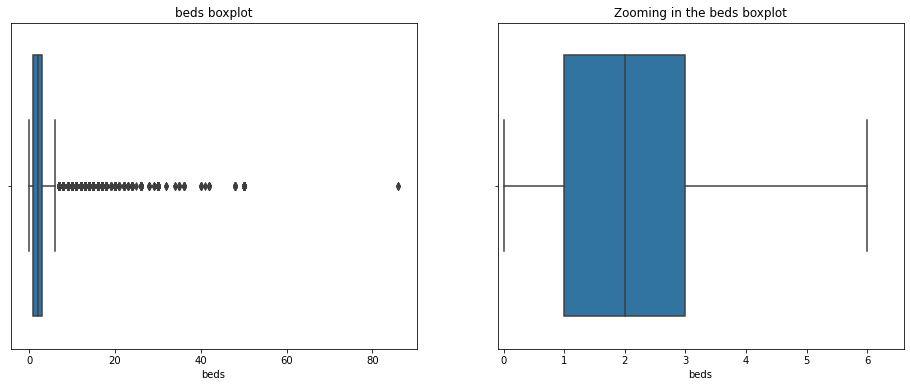

In [29]:
box_plot('beds')

In [30]:
get_max_fence('beds')
rows_before = df.shape[0]
df = df[df['beds'] <= get_max_fence('beds')]
print(f'{rows_before-df.shape[0]} rows were removed')

13846 rows were removed


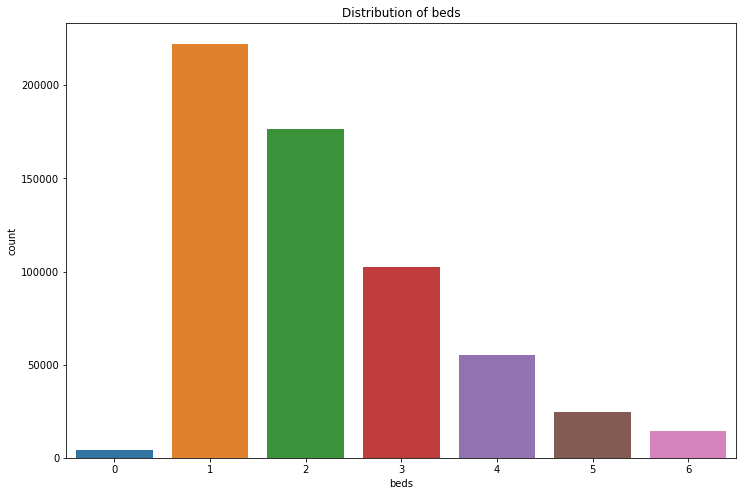

In [31]:
plt.figure(figsize=(12,8))
ax = sns.countplot('beds', data=df)
ax.set_xticklabels(map(int,df['beds'].index))
_ = ax.set_title('Distribution of beds')

**AMENITIES**

The analysis can get pretty complicated, if we choose to individually consider each amenity.<br>

**Unique amenities dataset sample:**

In [32]:
df['amenities'].unique()[0]

'{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,"Paid parking off premises","Smoking allowed",Doorman,Elevator,"Hot tub","Family/kid friendly","Suitable for events",Essentials,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in","Building staff","Private entrance","Hot water","Bed linens","Luggage dropoff allowed"}'

Since there is a lot of data for this regression, I will make an approximation:

The column `amenities` will be dropped, and another column called `n_amenities` will be created, containing the number of amenities each listing has. This way, we won't exactly analyze what the listing has to offer, but we get another parameter to take into consideration: <br>
### Host behavior

By taking a look at the data, you'll notice that it is hard to point out what kind of value would amenities bring to the listing. Sometimes, the same thing is written in a different way, and a deeper analysis just makes itself too hard to happen. But, since we're dealing with regular people, my hypothesis is that the effort put by the host to tell which amenities the listing has, indicates that the property is better taken care of. Therefore, it can be an indicator that **listings with more amenities are priced slightly higher**.

In [33]:
df['n_amenities'] = df['amenities'].str.split(',').apply(len)+1
df['n_amenities'] = df['n_amenities'].astype('int')
df.loc[df['amenities'] == '{}', 'n_amenities'] = df['n_amenities'].mode()
df = df.drop('amenities', axis=1)

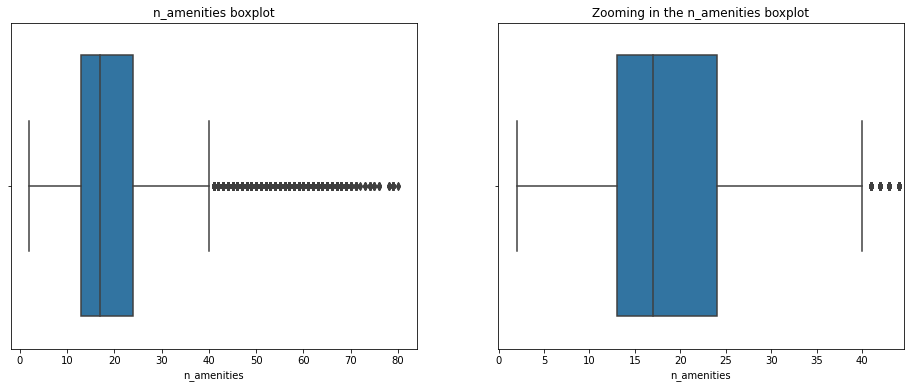

In [34]:
box_plot('n_amenities')

Removing entries with outliers on `n_amenities`:

In [35]:
print(get_max_fence('n_amenities'))
rows_before = df.shape[0]
df = df[df['n_amenities'] <= get_max_fence('n_amenities')]
print(f'{rows_before-df.shape[0]} rows were removed')

40.5
28408 rows were removed


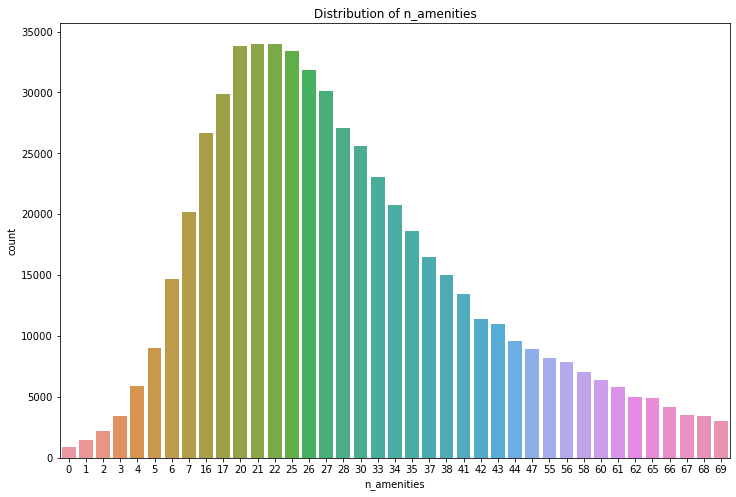

In [36]:
plt.figure(figsize=(12,8))
ax = sns.countplot('n_amenities', data=df)
ax.tick_params(axis='x')
ax.set_xticklabels(map(int,df['n_amenities'].index))
# ax.locator_params(integer=True)
_ = ax.set_title('Distribution of n_amenities')

### Correlation heatmap

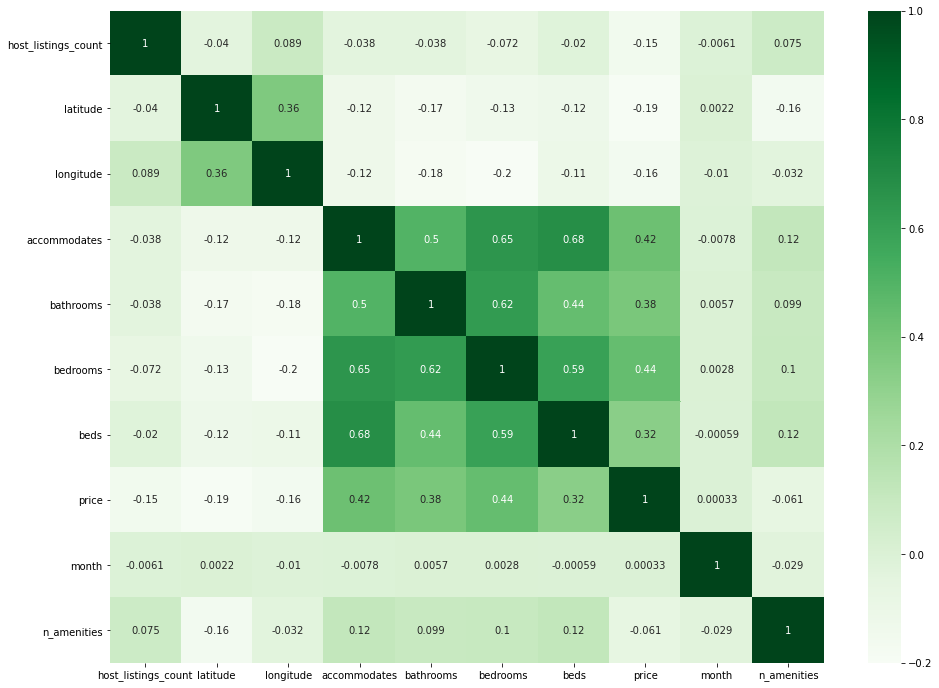

In [37]:
df.head()
corr = df.corr()
plt.figure(figsize=(16,12))
_ = sns.heatmap(df.corr(), annot=True, cmap='Greens')

`host_listings_count` has a negative correlation with `price`, which can either mean that hosts with fewer listings usually charge more, or that the dataset is not divided equally.

In [38]:
#COORDINATES TO PLOT THE MAP
box = (df.longitude.min(), df.longitude.max(), df.latitude.min(), df.latitude.max())
box1 = (-43.7370,-43.1041,-23.0729,-22.7497)

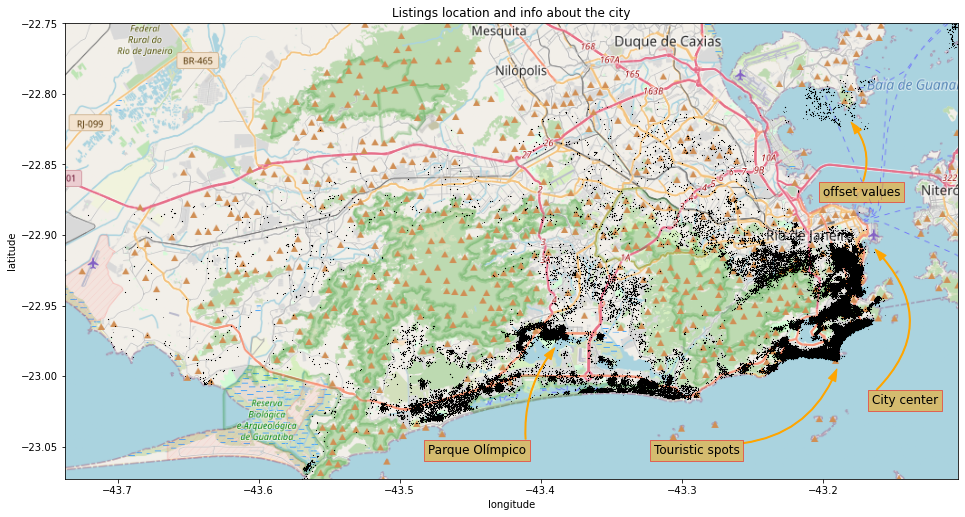

In [39]:
fig, ax= plt.subplots()
fig.set_size_inches(16,12)
a = plt.imread('https://i.ibb.co/52dDkxT/map-8.png')
ax.imshow(a,zorder=0, extent=(box[0],-43.1041,-23.082,box[3]), aspect='equal')
ax.set_title('Listings location and info about the city')
ax.set_xlim(box[0],box[1])
ax.set_ylim(box[2],box[3])#-23.0729
ax.annotate('offset values',
            xy=(-43.18, -22.82),
            xytext=(-43.2,-22.872), backgroundcolor='yellow',bbox=dict(facecolor='#ffa500', alpha=0.5, edgecolor='red', joinstyle='round'),
            arrowprops=dict(headwidth=8, width=1, color='#ffa500', connectionstyle="arc3, rad=0.3"),
            fontsize=12)
ax.annotate('Parque Olímpico',
            xy=(-43.39, -22.98),
            xytext=(-43.48,-23.055), backgroundcolor='yellow',bbox=dict(facecolor='#ffa500', alpha=0.5, edgecolor='red', joinstyle='round'),
            arrowprops=dict(headwidth=8, width=1, color='#ffa500', connectionstyle="arc3, rad=-0.2"),
            fontsize=12)
ax.annotate('City center',
            xy=(-43.163, -22.91),
            xytext=(-43.165,-23.02), backgroundcolor='yellow',bbox=dict(facecolor='#ffa500', alpha=0.5, edgecolor='red', joinstyle='round'),
            arrowprops=dict(headwidth=8, width=1, color='#ffa500', connectionstyle="arc3, rad=0.5"),
            fontsize=12)
ax.annotate('Touristic spots',
            xy=(-43.19, -22.995),
            xytext=(-43.32,-23.055), backgroundcolor='yellow',bbox=dict(facecolor='#ffa500', alpha=0.5, edgecolor='red', joinstyle='round'),
            arrowprops=dict(headwidth=8, width=1, color='#ffa500', connectionstyle="arc3, rad=0.3"),
            fontsize=12)
_ = sns.scatterplot(x='longitude', y='latitude', data=df, ax=ax, zorder=1,color='black',alpha=0.6, s=0.1,edgecolor=None)

Some datapoints have a weird position(on the top right of the map above). But it seems to be a common offset to every listing for the Island above it(called Ilha do governador). For now, we leave it that way.

In [40]:
df_density_mapbox = df.sample(n=15000)
map_center = {'lat':df_density_mapbox.latitude.mean(), 'lon':df_density_mapbox.longitude.mean()}
fig = px.density_mapbox(df_density_mapbox, lat='latitude', lon='longitude',z='price',title=10*'  '+'Daily Price density', radius=2.5,
                        center=map_center, zoom=10,
                        mapbox_style='stamen-terrain')
fig.show()

The neighborhoods with the highest prices are between the south zone and city center. It is important to notice that there is a pattern on the map:

1. Zones with the highest prices are usually closer to beaches and to touristic spots.
2. There is a high price spike close to Parque Olímpico, which is where some international festivals happen, such as Rock in Rio.

### Encoding variables

Now that our dataset is clean and organized, it's time to deal with categorical variables, such as: `property_type`, `host_is_superhost`, `require_guest_profile_picture`, and `require_guest_phone_verification`. We'll set 'f' equal to 0  and 't' equal to 1 in every categorial variable but `property_type`, since they are all binary. On property type, we will first experiment with label encoding, and change the method if the result is not satisfying.

In [41]:
df_label_encoder = df.copy()
for column in ('host_is_superhost', 'require_guest_profile_picture', 'require_guest_phone_verification'):
    df_label_encoder.loc[df_label_encoder[column] == 'f', column] = 0
    df_label_encoder.loc[df_label_encoder[column] == 't', column] = 1
    df_label_encoder[column] = df_label_encoder[column].astype(int)
encoder = LabelEncoder()


df_label_encoder['property_type'] = encoder.fit_transform(df_label_encoder['property_type']) 

print('Columns encoded')

Columns encoded


Defining the method for evaluation

We'll define a function that will return three evaluation methods:

1. Root mean squared error
2. Mean absolute error
3. R² score

Both evaluation methods above will be compared. Mean absolute error will be used as an 'anchor'. Root mean squared error will be used to evaluate errors abnormal to the error average.


R² score will be used as a way to evaluate how well our model can explain variance in the test dataset. That is the best measure we can get to evaluate a model, since people can price their properties in a variety of unpredictable ways.

In [42]:
def evaluate(model_name, y_test, predictions):
    RMSE = np.sqrt(mean_squared_error(y_test, predictions))
    MAE = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return f'model: {model_name}\nMean Absolute Error: {MAE}\nRoot Mean Square Error: {RMSE}\nR² Score: {round(r2*100, 2)}% \n--------------------------------------------'   

# Trying out regression models
![](https://c.mql5.com/31/423/regression-logo-200x200-4497.png)

Now, let's simply run our dataset and fit it into many models, to see which one performs better.<br>
This is a good way of initially selecting the best model to **hypertune**.

In [43]:
y = df_label_encoder['price']
columns_dropped =  ['price']
models = {'Random Forest':RandomForestRegressor(),
          'Lasso':Lasso(),
          'ElasticNet': ElasticNet(),
          'XGBRegressor': XGBRegressor(),
          'Linear Regression': LinearRegression(),
          'Linear SVR': LinearSVR(),
          'sgdregressor' : SGDRegressor(),
          'decision tree': DecisionTreeRegressor(),
          'Extra Tree Regressor': ExtraTreesRegressor()
}

X = df_label_encoder.drop(columns_dropped, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)
name = 'Extra Trees Regressor'
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(evaluate(name, y_test, predictions))

model: Random Forest
Mean Absolute Error: 17.801472586374473
Root Mean Square Error: 50.56516205885683
R² Score: 96.87% 
--------------------------------------------
model: Lasso
Mean Absolute Error: 181.0651638222365
Root Mean Square Error: 241.84743643322733
R² Score: 28.5% 
--------------------------------------------
model: ElasticNet
Mean Absolute Error: 185.44224750027965
Root Mean Square Error: 245.89719660261486
R² Score: 26.09% 
--------------------------------------------
model: XGBRegressor
Mean Absolute Error: 147.2225367232744
Root Mean Square Error: 201.93557596705776
R² Score: 50.15% 
--------------------------------------------
model: Linear Regression
Mean Absolute Error: 179.48715073473798
Root Mean Square Error: 240.11353376005465
R² Score: 29.53% 
--------------------------------------------


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



model: Linear SVR
Mean Absolute Error: 172.54306482587785
Root Mean Square Error: 253.2487265902574
R² Score: 21.6% 
--------------------------------------------
model: sgdregressor
Mean Absolute Error: 318754.3665308309
Root Mean Square Error: 412731.0127230227
R² Score: -208225344.43% 
--------------------------------------------
model: decision tree
Mean Absolute Error: 15.300097221833646
Root Mean Square Error: 63.387972520690035
R² Score: 95.09% 
--------------------------------------------
model: Extra Tree Regressor
Mean Absolute Error: 14.173481181185883
Root Mean Square Error: 48.38259359784582
R² Score: 97.14% 
--------------------------------------------


1. ExtraTreesRegressor was the best model so far. It has achieved a R² score of 97%, which means it dealt really well with data far from the mean.
2. RandomForest also achived a R² score of 97% but extra tree performed better on other measures.<br>
3. The MAE is also impressive(14 reais), but what is most surprising is the RMSE, which shows that our model didnt miss by much, on average.

Feature importance

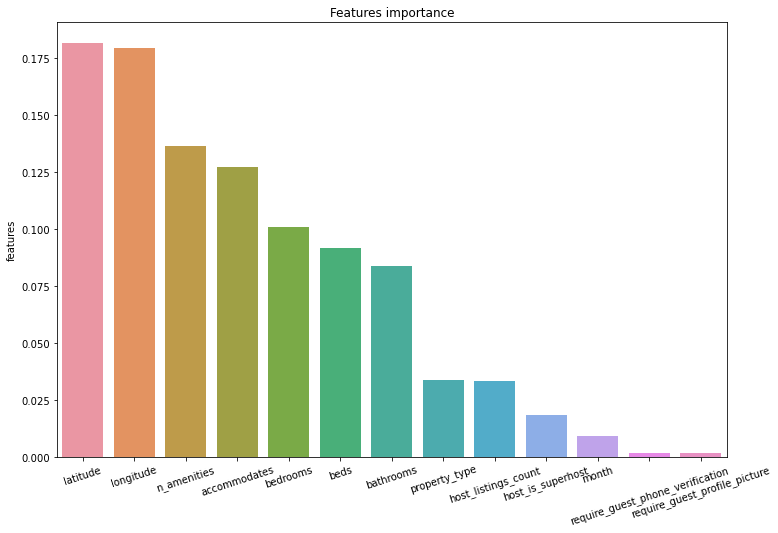

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
bp_df = pd.DataFrame({'features': model.feature_importances_}, index=X_test.columns)
bp_df = bp_df.sort_values(by='features', ascending=False)
ax.tick_params(axis='x', rotation=18)
_ = ax.set_title('Features importance')
_ = sns.barplot(x=bp_df.index, y='features', data=bp_df, ax = ax)

### Is there more room for performance improvement by removing columns?
<br><br>

In this part, we will try to remove a few columns and see the result to the model's performance.

Everytime we remove a new column, the column that was removed before is replaced, so that we can evaluate how each column influence the model individually.

So, let's remove these columns individually to see how the model performs:<br>
- `require_guest_phone_verification`
- `require_guest_profile_picture`
- `property_type`
- `host_listings_count`
- `host_is_superhost`

In [45]:
cols_lists = ['require_guest_phone_verification', 'require_guest_profile_picture',
              'property_type', 'bedrooms',
              'host_listings_count', 'host_is_superhost']
for column in cols_lists: 
    removed = X[column]
    X.drop(column, axis=1, inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)
    selected_model = ExtraTreesRegressor(random_state=1)
    selected_model.fit(X_train, y_train)
    predictions = selected_model.predict(X_test)
    print(f'col removed: {column}\n{evaluate(name, y_test, predictions)}')
    X = pd.concat([X, removed], axis=1)

col removed: require_guest_phone_verification
model: Extra Tree Regressor
Mean Absolute Error: 14.23004883157275
Root Mean Square Error: 48.64637591242516
R² Score: 97.11% 
--------------------------------------------
col removed: require_guest_profile_picture
model: Extra Tree Regressor
Mean Absolute Error: 14.243663100782003
Root Mean Square Error: 48.59296672804127
R² Score: 97.11% 
--------------------------------------------
col removed: property_type
model: Extra Tree Regressor
Mean Absolute Error: 14.628904148120467
Root Mean Square Error: 49.3875198160015
R² Score: 97.02% 
--------------------------------------------
col removed: bedrooms
model: Extra Tree Regressor
Mean Absolute Error: 14.73750047164694
Root Mean Square Error: 49.75073577012642
R² Score: 96.97% 
--------------------------------------------
col removed: host_listings_count
model: Extra Tree Regressor
Mean Absolute Error: 13.866833436084052
Root Mean Square Error: 47.72080481113938
R² Score: 97.22% 
------------

The model performed best by removing `host_listings_count`, so let's remove it from the dataset.

In [46]:
X.drop('host_listings_count', axis=1, inplace=True)

Now, let's remove each one of the other four variables, to see if their removal sums up to the improvement of the model.<br>
Removing `host_is_superhost`:

In [47]:
removed = X['host_is_superhost']
X.drop('host_is_superhost', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)
selected_model = ExtraTreesRegressor(random_state=1)
selected_model.fit(X_train, y_train)
predictions = selected_model.predict(X_test)
print(f'cols removed: host_is_superhost\n{evaluate(name, y_test, predictions)}')

cols removed: host_is_superhost
model: Extra Tree Regressor
Mean Absolute Error: 13.734960439806395
Root Mean Square Error: 47.496762603526484
R² Score: 97.24% 
--------------------------------------------


Removing `require_guest_phone_verification`:

In [48]:
column = 'require_guest_phone_verification'
removed = X[column]
X.drop(column, axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)
selected_model = ExtraTreesRegressor(random_state=1)
selected_model.fit(X_train, y_train)
predictions = selected_model.predict(X_test)
print(f'cols removed: {column}\n{evaluate(name, y_test, predictions)}')

cols removed: require_guest_phone_verification
model: Extra Tree Regressor
Mean Absolute Error: 13.742401953995657
Root Mean Square Error: 47.4679020742684
R² Score: 97.25% 
--------------------------------------------


Removing `require_guest_profile_picture`:

In [49]:
column = 'require_guest_profile_picture'
removed = X[column]
X.drop(column, axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)
selected_model = ExtraTreesRegressor(random_state=1)
selected_model.fit(X_train, y_train)
predictions = selected_model.predict(X_test)
print(f'cols removed: {column}\n{evaluate(name, y_test, predictions)}')

cols removed: require_guest_profile_picture
model: Extra Tree Regressor
Mean Absolute Error: 13.75228098519901
Root Mean Square Error: 47.47464948496547
R² Score: 97.24% 
--------------------------------------------


Although removing `require_guest_profile_picture` made our model slightly worse, I don't intend to put it back, because removing it makes the model faster and simpler, if you consider the intention is to make it **available for the general public**, and such information is not so easy to obtain from unexperienced hosts(a new host not knowing how to check if its profile requires a profile picture from the guest, for example).

Our final features are:

In [50]:
i=1
for feature in X.columns:
    print(f'Feature number {i}: {feature}')
    i+=1

Feature number 1: latitude
Feature number 2: longitude
Feature number 3: accommodates
Feature number 4: bathrooms
Feature number 5: beds
Feature number 6: month
Feature number 7: n_amenities
Feature number 8: property_type
Feature number 9: bedrooms


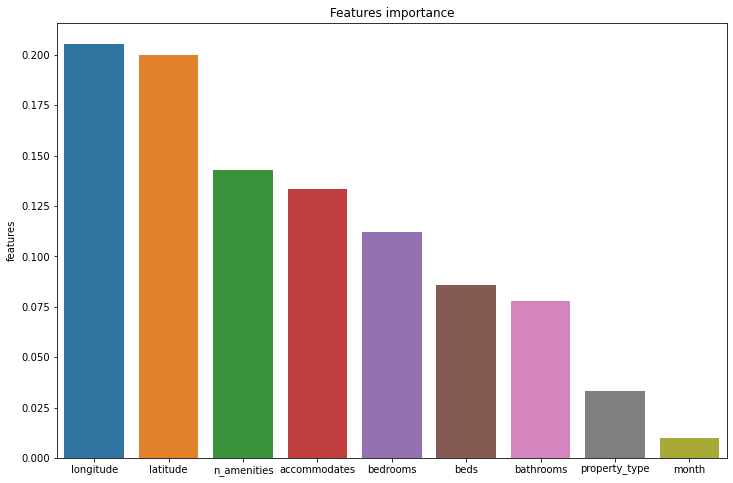

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
bp_df = pd.DataFrame({'features': selected_model.feature_importances_}, index=X_test.columns)
bp_df = bp_df.sort_values(by='features', ascending=False)
ax.tick_params(axis='x', rotation=0)
_ = ax.set_title('Features importance')
_ = sns.barplot(x=bp_df.index, y='features', data=bp_df, ax = ax)

### Conclusion

**The location is the most important feature for the model**: no surprises there. But what surprised me the most is: n_amenities is the third most important variable. In my point of view, this probably has two meanings:

1. Listings with more amenities are naturally more expensive(maintaining it costs more).
2. Hosts that take the time to write every single amenity probably put more work into renting it, and therefore, charge more.
<br>

`property_type` performed worse than expected. I suspect that it is because it has a high cardinality(too many categories), with little to no difference in meaning. So, probably digging deeper into each category and replacing them with more general categories could improve the performance of our model(maybe that can be included in a next version of the model).<br><br>
A further analysis will be done soon to know which conditions make the data the most unpredictable.<br><br>
Overall, I think the model performed great as a tool to give a initial pricing estimative for unexperienced hosts.